In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
#from pathlib import Path
#TRAIN_DIR = Path('./journey-springfield/train/simpsons_dataset')
#TEST_DIR = Path('./journey-springfield/testset/testset')

#Загрузка данных 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [ ]:
!nvidia-smi
torch.cuda.is_available()

Mon Nov 21 12:15:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Предобработка данных

При создании датасета добавляем дополнительную случайную трансформацию для тренировочных данных. Это увеличит вариативностью данных для обучения, что увеличит предсказательную способнось модели

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # дополнительная трансформация для тестовых данных для исключения переобучения
        transform_train = transforms.Compose([
            transforms.RandomRotation(degrees=(-20, 20)),
            transforms.RandomAutocontrast(p=0.2),
            transforms.RandomHorizontalFlip(p=0.2)
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'train':
            x = transform_train(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # классы train + val
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

Некоторые персонажи встречаются крайне редко, что не даёт возможности их запомнить. Увеличим количество малочисленных классов до 100, сделав копии путей до них.

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Посмотрим, что у нас получилось.
print_dct(dct_path_train)

abraham_grampa_simpson	[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0030.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0788.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0905.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0177.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0012.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0132.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0466.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0383.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0471.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0593.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0854.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0187.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0191.jpg'), PosixPath('train/simpsons_d

In [ ]:
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	730
agnes_skinner	34
apu_nahasapeemapetilon	498
barney_gumble	85
bart_simpson	1074
carl_carlson	78
charles_montgomery_burns	954
chief_wiggum	789
cletus_spuckler	38
comic_book_guy	375
disco_stu	6
edna_krabappel	366
fat_tony	22
gil	22
groundskeeper_willie	97
homer_simpson	1797
kent_brockman	398
krusty_the_clown	965
lenny_leonard	248
lionel_hutz	2
lisa_simpson	1083
maggie_simpson	102
marge_simpson	1033
martin_prince	57
mayor_quimby	197
milhouse_van_houten	863
miss_hoover	14
moe_szyslak	1161
ned_flanders	1163
nelson_muntz	286
otto_mann	26
patty_bouvier	58
principal_skinner	955
professor_john_frink	52
rainier_wolfcastle	36
ralph_wiggum	71
selma_bouvier	82
sideshow_bob	702
sideshow_mel	32
snake_jailbird	44
troy_mcclure	6
waylon_smithers	145


In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [ ]:
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	730
agnes_skinner	100
apu_nahasapeemapetilon	498
barney_gumble	100
bart_simpson	1074
carl_carlson	100
charles_montgomery_burns	954
chief_wiggum	789
cletus_spuckler	100
comic_book_guy	375
disco_stu	100
edna_krabappel	366
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1797
kent_brockman	398
krusty_the_clown	965
lenny_leonard	248
lionel_hutz	100
lisa_simpson	1083
maggie_simpson	102
marge_simpson	1033
martin_prince	100
mayor_quimby	197
milhouse_van_houten	863
miss_hoover	100
moe_szyslak	1161
ned_flanders	1163
nelson_muntz	286
otto_mann	100
patty_bouvier	100
principal_skinner	955
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	702
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	145


In [ ]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [ ]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	730
agnes_skinner	100
apu_nahasapeemapetilon	498
barney_gumble	100
bart_simpson	1074
carl_carlson	100
charles_montgomery_burns	954
chief_wiggum	789
cletus_spuckler	100
comic_book_guy	375
disco_stu	100
edna_krabappel	366
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1797
kent_brockman	398
krusty_the_clown	965
lenny_leonard	248
lionel_hutz	100
lisa_simpson	1083
maggie_simpson	102
marge_simpson	1033
martin_prince	100
mayor_quimby	197
milhouse_van_houten	863
miss_hoover	100
moe_szyslak	1161
ned_flanders	1163
nelson_muntz	286
otto_mann	100
patty_bouvier	100
principal_skinner	955
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	702
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	145


In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

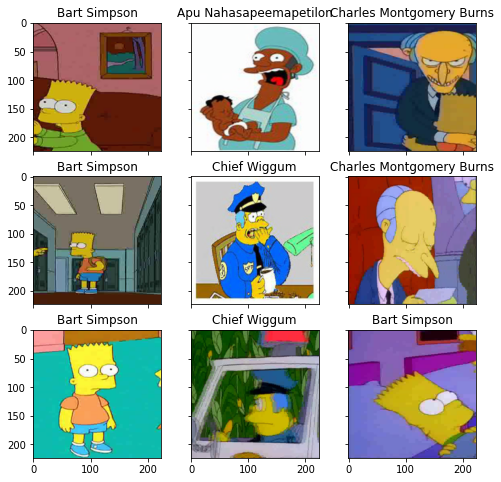

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Исходный тренировочный набор увеличился на 1000 изображений

In [ ]:
print(len(new_train_files) - len(train_files)) 
print(len(val_files) + len(new_train_files)) 

1138
4187
22071


#Обучение модели

В качестве модели взят предобученый vgg16 с batch norm

In [ ]:
from torchvision import transforms, models

# Создаём сеть
model = models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
n_classes = len(np.unique(train_val_labels))
n_classes

42

In [ ]:
# переопределим выход нашей модели на количество классов
model.classifier[6] = nn.Linear(4096,n_classes)

In [ ]:
# Зафиксируем все веса извлечения фич модели, обучаться она будет на слоях классификации
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# посмотрим какие параметры нейросети мы учим
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    val_dataset = SimpsonsDataset(val_files, mode='val')
    train_dataset = SimpsonsDataset(train_files, mode='train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        #scheduler уменьшит lr на половину за 10 эпох
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.85)
        model = model.to(DEVICE)

        for epoch in range(epochs):
            print('lr', scheduler.get_last_lr())
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.save(model.state_dict(), 'weights.pth')
            scheduler.step()
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))
print(model)

we will classify :42
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [ ]:
#model.load_state_dict(torch.load('./weights.pth'))

In [ ]:
history = train(train_files=new_train_files, val_files=val_files, model=model, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

lr [0.001]
loss 2.053750179059765


epoch:  10%|█         | 1/10 [05:22<48:24, 322.70s/it]


Epoch 001 train_loss: 2.0538     val_loss 1.1736 train_acc 0.4709 val_acc 0.6984
lr [0.001]
loss 0.9408301042246622


epoch:  20%|██        | 2/10 [10:56<43:54, 329.36s/it]


Epoch 002 train_loss: 0.9408     val_loss 0.8245 train_acc 0.7473 val_acc 0.7779
lr [0.00085]
loss 0.5859045378582186


epoch:  30%|███       | 3/10 [16:30<38:39, 331.30s/it]


Epoch 003 train_loss: 0.5859     val_loss 0.7146 train_acc 0.8378 val_acc 0.8113
lr [0.00085]
loss 0.4492869309679397


epoch:  40%|████      | 4/10 [22:07<33:21, 333.51s/it]


Epoch 004 train_loss: 0.4493     val_loss 0.7535 train_acc 0.8698 val_acc 0.8118
lr [0.0007224999999999999]
loss 0.3308427765935466


epoch:  50%|█████     | 5/10 [27:42<27:50, 334.18s/it]


Epoch 005 train_loss: 0.3308     val_loss 0.6981 train_acc 0.9059 val_acc 0.8326
lr [0.0007224999999999999]
loss 0.2893052644589368


epoch:  60%|██████    | 6/10 [33:10<22:08, 332.14s/it]


Epoch 006 train_loss: 0.2893     val_loss 0.6972 train_acc 0.9150 val_acc 0.8309
lr [0.000614125]
loss 0.23499945653975343


epoch:  70%|███████   | 7/10 [38:38<16:32, 330.80s/it]


Epoch 007 train_loss: 0.2350     val_loss 0.7052 train_acc 0.9298 val_acc 0.8314
lr [0.000614125]
loss 0.2044395163265338


epoch:  80%|████████  | 8/10 [44:08<11:01, 330.52s/it]


Epoch 008 train_loss: 0.2044     val_loss 0.6988 train_acc 0.9397 val_acc 0.8369
lr [0.00052200625]
loss 0.16538103127960815


epoch:  90%|█████████ | 9/10 [49:33<05:28, 328.57s/it]


Epoch 009 train_loss: 0.1654     val_loss 0.6295 train_acc 0.9508 val_acc 0.8486
lr [0.00052200625]
loss 0.14776665619211


epoch: 100%|██████████| 10/10 [55:01<00:00, 328.42s/it]


Epoch 010 train_loss: 0.1478     val_loss 0.6777 train_acc 0.9580 val_acc 0.8500


epoch: 100%|██████████| 10/10 [55:03<00:00, 330.31s/it]


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

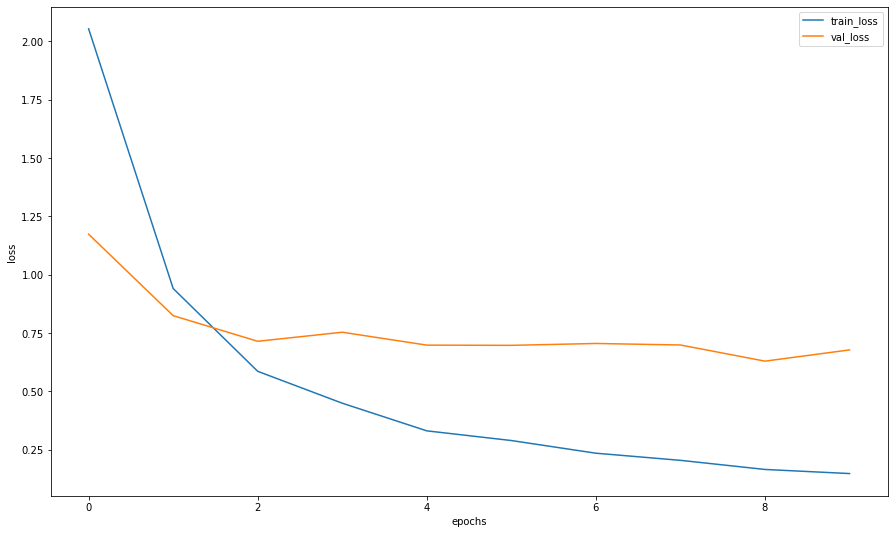

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

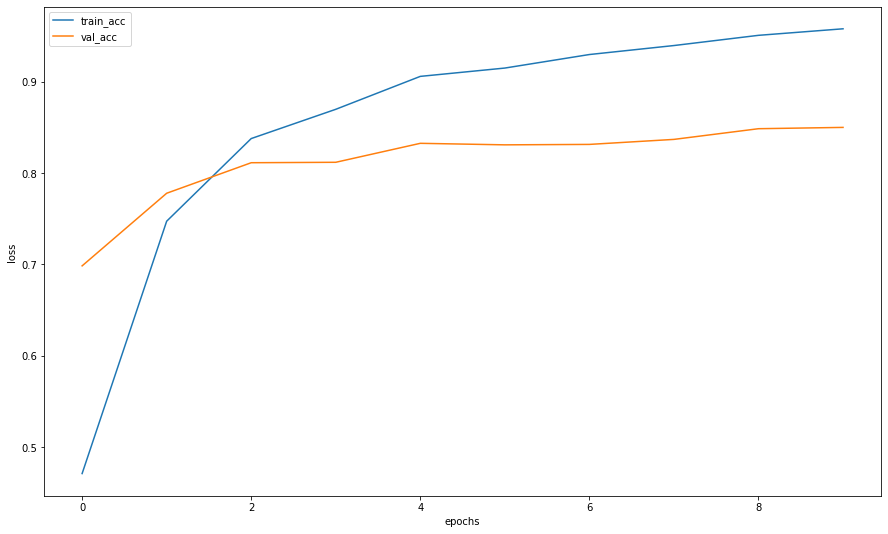

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 200)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.855

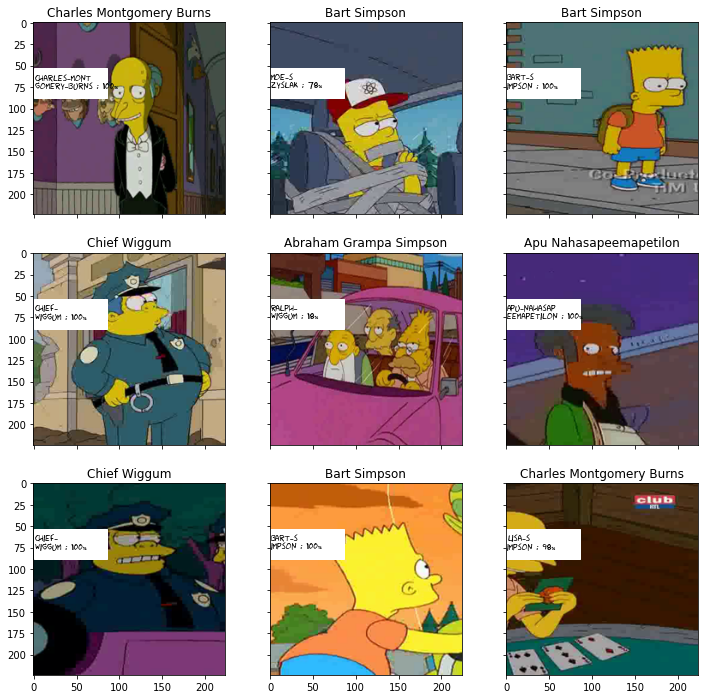

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

import pandas as pd
#my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.to_csv('./my_model_submision.csv', index=False)

In [ ]:
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


Лучший скор

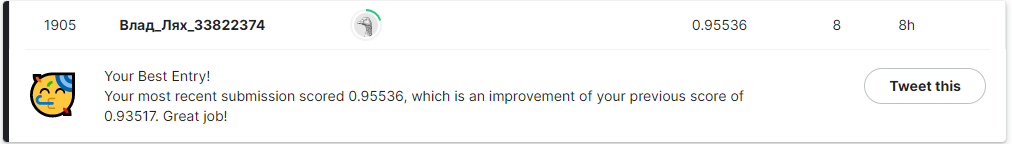